In [19]:
# Fake News Detection - FIXED Training Pipeline
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Download stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

In [20]:
# ============================================================================
# 1️⃣ LOAD DATASETS
# ============================================================================


data_True = pd.read_csv("True.csv")
data_Fake = pd.read_csv("Fake.csv")

print(f"\nTrue News Dataset: {data_True.shape}")
print(f"Fake News Dataset: {data_Fake.shape}")

# Add labels
data_True['label'] = 1  # 1 = Real News
data_Fake['label'] = 0  # 0 = Fake News

# Combine datasets
data = pd.concat([data_True, data_Fake], ignore_index=True, axis=0)

# Shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nCombined Dataset: {data.shape}")
print("\nClass Distribution:")
print(data['label'].value_counts())


True News Dataset: (21417, 4)
Fake News Dataset: (23481, 4)

Combined Dataset: (44898, 5)

Class Distribution:
label
0    23481
1    21417
Name: count, dtype: int64


In [21]:
# ============================================================================
# 2️⃣ DATA PREPROCESSING
# ============================================================================

# Combine title and text
data['Combined'] = data['title'].astype(str) + ' ' + data['text'].astype(str)

# Text cleaning function
def wordopt(text):
    """Clean and preprocess text data"""
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("\\W", " ", text)

    word_list = text.split()
    text_clean = [word for word in word_list if word not in stop_words]

    return ' '.join(text_clean)

print("\nCleaning text data...")
# CRITICAL FIX: Clean BEFORE splitting
data['Combined'] = data['Combined'].apply(wordopt)

print("Sample of cleaned text:")
print(data['Combined'].iloc[0][:200] + "...")

<>:12: SyntaxWarning: invalid escape sequence '\['
<>:13: SyntaxWarning: invalid escape sequence '\S'
<>:16: SyntaxWarning: invalid escape sequence '\w'
<>:12: SyntaxWarning: invalid escape sequence '\['
<>:13: SyntaxWarning: invalid escape sequence '\S'
<>:16: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-2518051540.py:12: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
/tmp/ipython-input-2518051540.py:13: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
/tmp/ipython-input-2518051540.py:16: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)



Cleaning text data...
Sample of cleaned text:
breaking gop chairman grassley enough demands trump jr testimony donald trump white house chaos trying cover russia problems mounting hour refuse acknowledge problems surrounding fake news hoax howeve...


In [22]:
# ============================================================================
# 3️⃣ FEATURE EXTRACTION
# ============================================================================

# NOW use the cleaned data
X = data['Combined']
y = data['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# TF-IDF Vectorization
vectorization = TfidfVectorizer(max_features=5000)
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

print(f"\nTF-IDF features: {xv_train.shape[1]}")


Training set: 33673 samples
Testing set: 11225 samples

TF-IDF features: 5000


In [23]:
# ============================================================================
# 4️⃣ MODEL TRAINING
# ============================================================================
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(xv_train, y_train)

print("\nModel trained successfully!")


Model trained successfully!



Accuracy: 0.9873 (98.73%)

Classification Report:
              precision    recall  f1-score   support

   Fake News       0.99      0.98      0.99      5871
   Real News       0.98      0.99      0.99      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225


Confusion matrix saved as 'confusion_matrix.png'


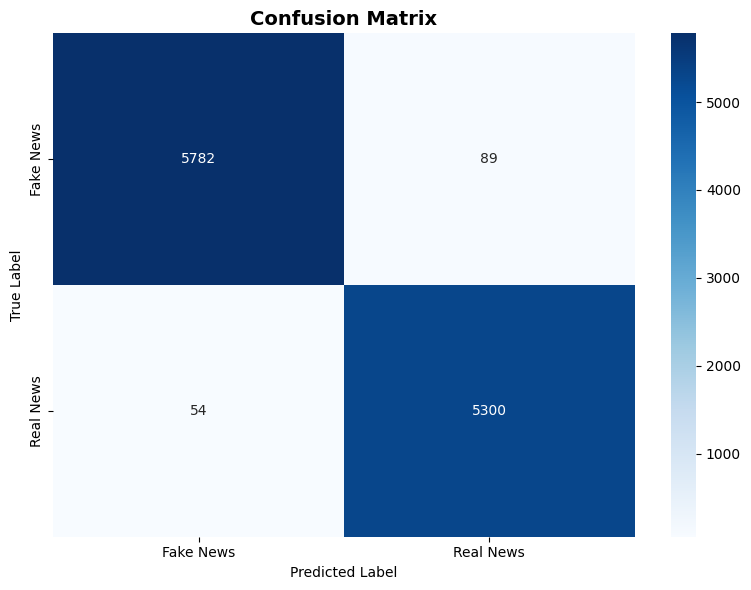

In [24]:
# ============================================================================
# 5️⃣ MODEL EVALUATION
# ============================================================================

# Predictions
pred_lr = model.predict(xv_test)
pred_proba = model.predict_proba(xv_test)

# Accuracy
accuracy = accuracy_score(y_test, pred_lr)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, pred_lr, target_names=['Fake News', 'Real News']))

# Confusion Matrix
cm = confusion_matrix(y_test, pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved as 'confusion_matrix.png'")
plt.show()
plt.close()

In [25]:
# ============================================================================
# 6️⃣ SAVE MODEL AND VECTORIZER
# ============================================================================
print("\n" + "=" * 80)
print("STEP 6: Saving Model and Vectorizer")
print("=" * 80)

# Save model
joblib.dump(model, 'fake_news_model.pkl')
print("Model saved: fake_news_model.pkl")

# Save vectorizer
joblib.dump(vectorization, 'tfidf_vectorizer.pkl')
print("Vectorizer saved: tfidf_vectorizer.pkl")

# Save stopwords for consistency
joblib.dump(stop_words, 'stopwords.pkl')
print("Stopwords saved: stopwords.pkl")


STEP 6: Saving Model and Vectorizer
Model saved: fake_news_model.pkl
Vectorizer saved: tfidf_vectorizer.pkl
Stopwords saved: stopwords.pkl


In [26]:
# ============================================================================
# 7️⃣ TEST PREDICTION FUNCTION
# ============================================================================
print("\n" + "=" * 80)
print("STEP 7: Testing Prediction Function")
print("=" * 80)

def predict_news(news_text):
    """Predict if news is fake or real"""
    # Clean text
    cleaned_text = wordopt(news_text)

    # Vectorize
    vectorized_text = vectorization.transform([cleaned_text])

    # Predict
    prediction = model.predict(vectorized_text)[0]
    probability = model.predict_proba(vectorized_text)[0]

    return prediction, probability

# Test samples
test_samples = [
    ("WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress on Friday demanded that President Donald Trump investigate whether former President Barack Obama abused his power.", 1),
    ("Donald Trump just couldn't wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star took to Twitter to tweet his greetings to Americans.", 0),
    ("The Federal Reserve announced today that interest rates will remain unchanged following their monthly policy meeting. Economic indicators show steady growth.", 1),
]

print("\nTesting sample predictions:")
for i, (sample, true_label) in enumerate(test_samples, 1):
    pred, prob = predict_news(sample)
    label = "Real News" if pred == 1 else "Fake News"
    true_label_str = "Real News" if true_label == 1 else "Fake News"
    confidence = prob[pred] * 100
    correct = "✓" if pred == true_label else "✗"

    print(f"\n{i}. {sample[:60]}...")
    print(f"   True: {true_label_str}")
    print(f"   Predicted: {label} (Confidence: {confidence:.2f}%) {correct}")


STEP 7: Testing Prediction Function

Testing sample predictions:

1. WASHINGTON (Reuters) - The head of a conservative Republican...
   True: Real News
   Predicted: Real News (Confidence: 99.70%) ✓

2. Donald Trump just couldn't wish all Americans a Happy New Ye...
   True: Fake News
   Predicted: Fake News (Confidence: 91.93%) ✓

3. The Federal Reserve announced today that interest rates will...
   True: Real News
   Predicted: Fake News (Confidence: 78.29%) ✗


In [27]:
# ============================================================================
# 8️⃣ FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)
print(f"\nDataset Size: {len(data):,} articles")
print(f"Real News: {(data['label']==1).sum():,} articles")
print(f"Fake News: {(data['label']==0).sum():,} articles")
print(f"\nTraining Samples: {len(X_train):,}")
print(f"Testing Samples: {len(X_test):,}")
print(f"\nModel Accuracy: {accuracy*100:.2f}%")
print(f"\nFiles Saved:")
print("  - fake_news_model.pkl")
print("  - tfidf_vectorizer.pkl")
print("  - stopwords.pkl")
print("  - confusion_matrix.png")

print("\n" + "=" * 80)
print("TRAINING COMPLETE! Ready for deployment.")
print("=" * 80)


PROJECT SUMMARY

Dataset Size: 44,898 articles
Real News: 21,417 articles
Fake News: 23,481 articles

Training Samples: 33,673
Testing Samples: 11,225

Model Accuracy: 98.73%

Files Saved:
  - fake_news_model.pkl
  - tfidf_vectorizer.pkl
  - stopwords.pkl
  - confusion_matrix.png

TRAINING COMPLETE! Ready for deployment.
